# Test Plan
For every algorithm developed it is important to design some test cases that the algorithm should pass. For an algorithm that generates summaries that can be slightly difficult. For systems that take input from one known language to another there are established techniques that are avalable but for our project we need to come up with something different. The solution we came up with for his is to generate test cases "on the fly" and prompt a user to reverse the given summary for comparison. We do this by generating (or reading in) some sentences, summarizing these sentences, and then comparing the human guess as to what the emojis mean to the input sentence. The general flow for this process is as follows

   1. Generate (or read) sentences
   2. Summarize each of the sentences
   3. Take the top 20 sentences, sorted by the certainty score
   4. For each machine translated sentence:
       1. Provide the user with the emojis
       2. Provide the user with an approximate sentence length
       3. Prompt the user to tranlate the emojis into a sentence
   5. For each machine translated sentence-user translated sentence pair:
       1. Calculate the distance between the two sentences using sent2vec (might need another metric)

After we have the list of numerical scores for the translations we can do some analysis on how the algorithm actually performs.

### Issues
1. Nothing to compare the cosine similarity against. Need to do some testing to determine what a "good" number is.
2. The dataset we have has too many complex sentences. We should begin testing with simpler inputs

### Sentence Generation
The sentences are gathered from the [Stanford NLP research group's NMT dataset](https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2012.en). All of these sentences will be loaded into memory, filtered based on length, and cleaned. 

In [15]:
# Load the sentences
file_path = "data/tst2012.en"
testing_sentences = []
with open(file_path, "r") as sents:
    testing_sentences = [sent for sent in sents]

In [16]:
# Filter the sentences based on an upper and lower bound for the sentence length
from nltk import word_tokenize
word_limit_lower = 5
word_limit_upper = 10
testing_sentences = list(filter(lambda sent: len(word_tokenize(sent)) <= word_limit_upper and 
                                             len(word_tokenize(sent)) >= word_limit_lower, testing_sentences))

In [18]:
# Clean the sentence
testing_sentences = [testing_sentence.replace("&apos;", "'") for testing_sentence in testing_sentences]

In [19]:
# Query how many sentences are in the current dataset
print(f"{len(testing_sentences)} sentences in dataset")

323 sentences in dataset


### Sentence Summarization
To do this we will just be using an exported Python V1 program that is just the NaiveEmojiTranslation notebook exported to .py. We summarize with the current best known params based on some limited observation. The sentences will be summarized and then the top thirty summarizations with the highest summarization scores are returned to prompt the user with

In [20]:
import warnings; warnings.simplefilter('ignore')               # cosine distance gives warnings when div by 0
from NaiveEmojiTranslation_V1 import summarize, lemmatizerNLTK # Exported NaiveEmojiTranslation to Python file as of October 24th

# Summarize each testing sentence with the current best known parameters
summarized_sentences = []
i = 0

for sentence in testing_sentences:
        
    i += 1
    if i % 25 == 0:
        print(i, ":", i / len(testing_sentences))
    
    summarized_sentences.append(summarize(sentence, keep_stop_words=True, 
                                  lemma_func=lemmatizerNLTK.lemmatize, scoring_func=scoring_function))

    # TODO: While we are summarizing this massive amount of data we can also record average summarization times
    # TODO: Print out more information (such as time) rather than just the percentage

25 : 0.07739938080495357
50 : 0.15479876160990713
75 : 0.23219814241486067
100 : 0.30959752321981426
125 : 0.38699690402476783
150 : 0.46439628482972134
175 : 0.541795665634675
200 : 0.6191950464396285
225 : 0.6965944272445821
250 : 0.7739938080495357
275 : 0.8513931888544891
300 : 0.9287925696594427


In [268]:
# Sort the sentences by their uncertainty scores. This is imported as a generic scoring
# function so that it can be swapped in and out easily
from NaiveEmojiTranslation_V1 import score_summarization_result_average as scoring_function

import pickle

# Sort the list by the scoring function
summarized_sentences = [x for x in summarized_sentences if len(x.uncertainty_scores) >= 1]
summarized_sentences_sorted = list(sorted(summarized_sentences, key=lambda x: sum(x.uncertainty_scores) / len(x.uncertainty_scores)))

with open('summaries.pkl', 'wb') as f:
    pickle.dump(summarized_sentences_sorted, f)

# Choose only the top 30 summaries
testing_summaries = summarized_sentences_sorted[:34]

print("Emoji Sequence, Target Length, Your Guess")
for summary in testing_summaries:
    print(summary.emojis + ", " + str(" ".join(summary.n_grams)) + ", ")

Emoji Sequence, Target Length, Your Guess
🙆🙏, okay thank you very much, 
🐾⌚️🎮, cat were watching other cat watch this video, 
👥💭🐆, people seem to think politics is sexy, 
👤👥❤️🚣, i represent people on death row, 
🎃🐢, this is a dead turtle, 
🙏, thank you very much, 
🙏, thank you very much, 
🙏, thank you very much, 
🙅💞👍, it 's not moving like that, 
🚯💨🌽🔗, and sure we could find fast food chain, 
🖇💕👥, it connected those two people, 
❤️🏈🐛, death penalty in america is defined by error, 
👤🙊👋, i knew she had come to say goodbye, 
👤🔙👖, and i went back to work, 
🎬👭🎍, procuring software usually take a couple of year, 
🐾🎮, even cat were watching this video, 
🚥🌎, go home to where, 
🌛✂️, the first cut, 
👤🙍, and this made me really sad, 
👤💭🔮, one i thought had a kidney stone, 
🕥🔮🍒, the underwater part wa captured in a stone pit, 
🚯🈸💡, no one ha to green-light your idea, 
💁🙆, and his answer wa yes, 
😲🍏, and i wa shocked and shaken to the core, 
🔍🌄, is it something about the detail or the color, 
👤🚲🍬, 

In [264]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
sns.set_context("poster")
sns.set_style("whitegrid")

summary_data = pd.DataFrame()
summary_data["Summary Scores"] = [scoring_function(summarized_sentence) for summarized_sentence in summarized_sentences]
summary_data["Sentence Length"] = [len(" ".join(summarized_sentence.n_grams).split(" ")) for summarized_sentence in summarized_sentences]

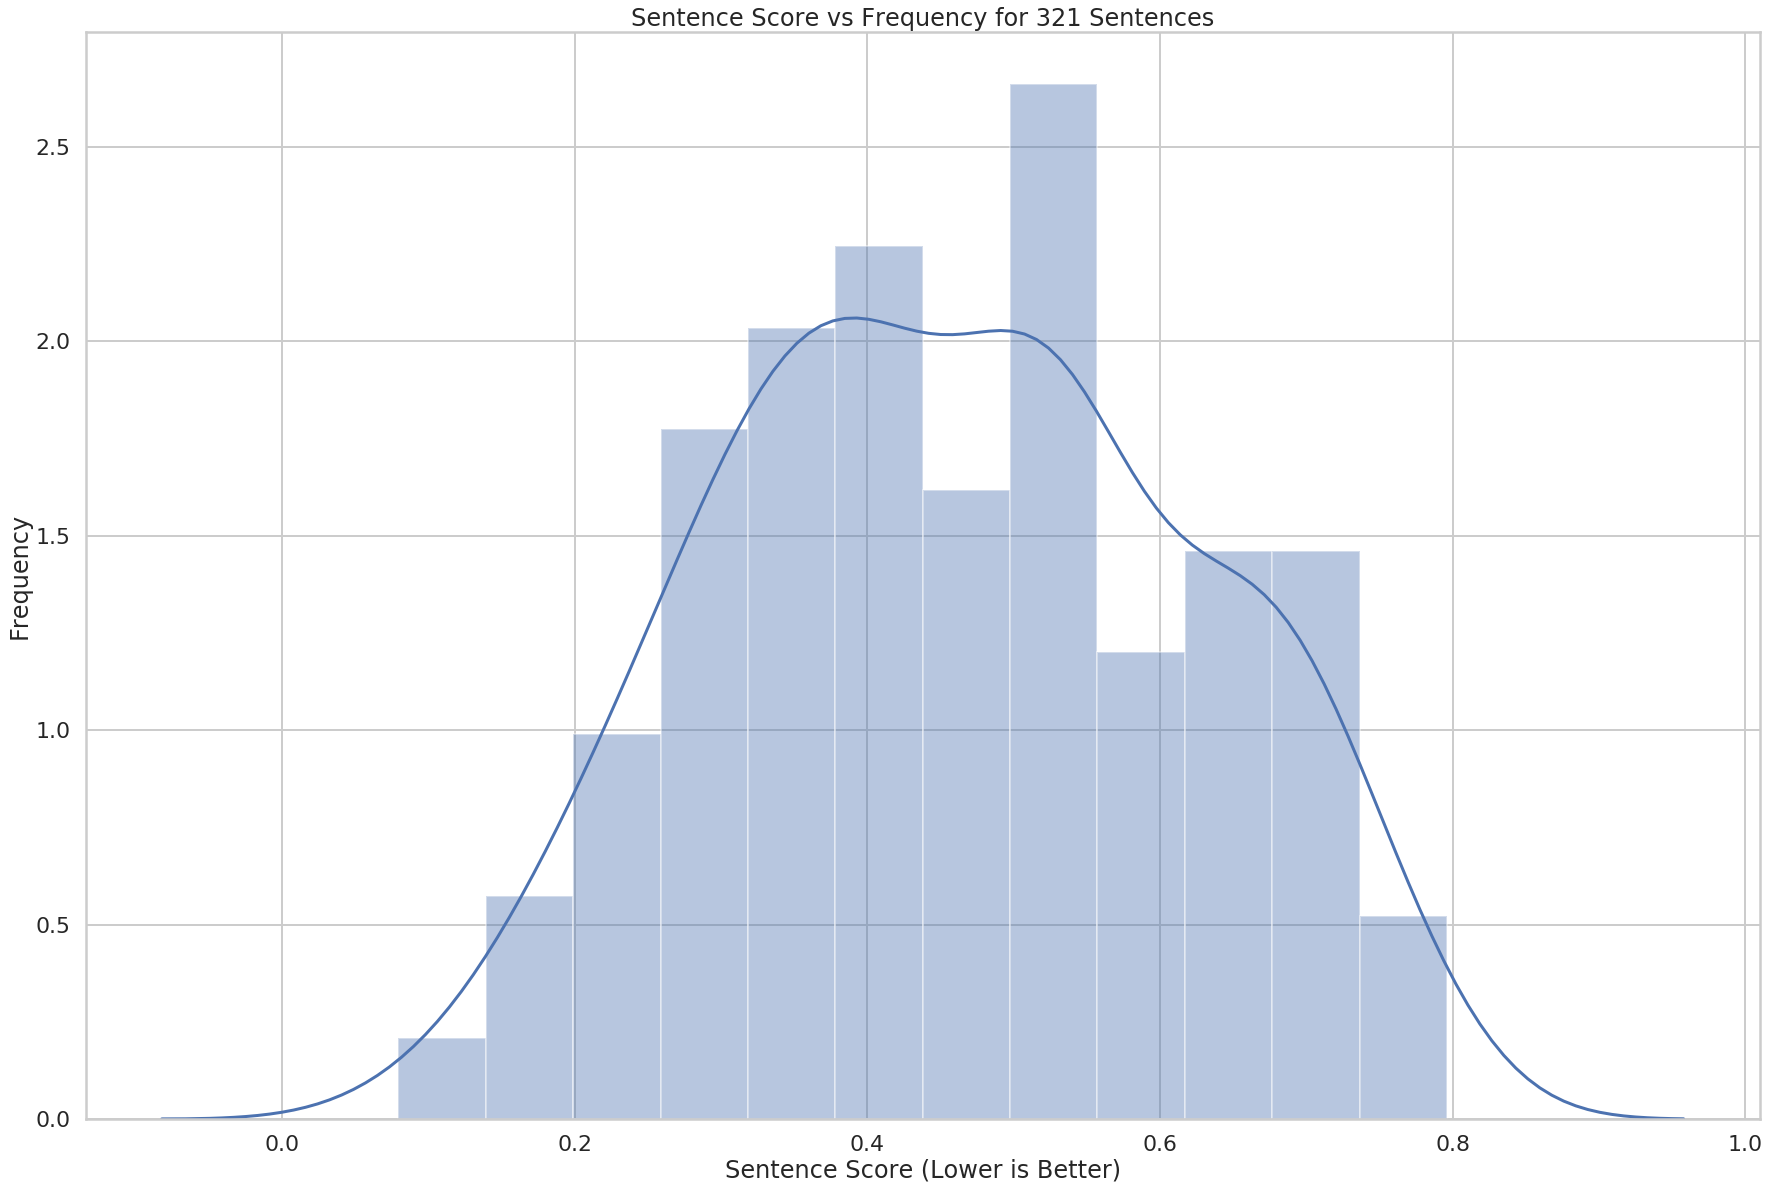

In [267]:
n_bins = len(xs) // 25
sns.distplot(summary_data["Summary Scores"], bins=n_bins)
plt.xlabel('Sentence Score (Lower is Better)')
plt.ylabel('Frequency')
plt.title("Sentence Score vs Frequency for {} Sentences".format(len(summary_data["Summary Scores"])))
plt.savefig("./plots/SentenceScoreVsFrequency.png")
plt.show()

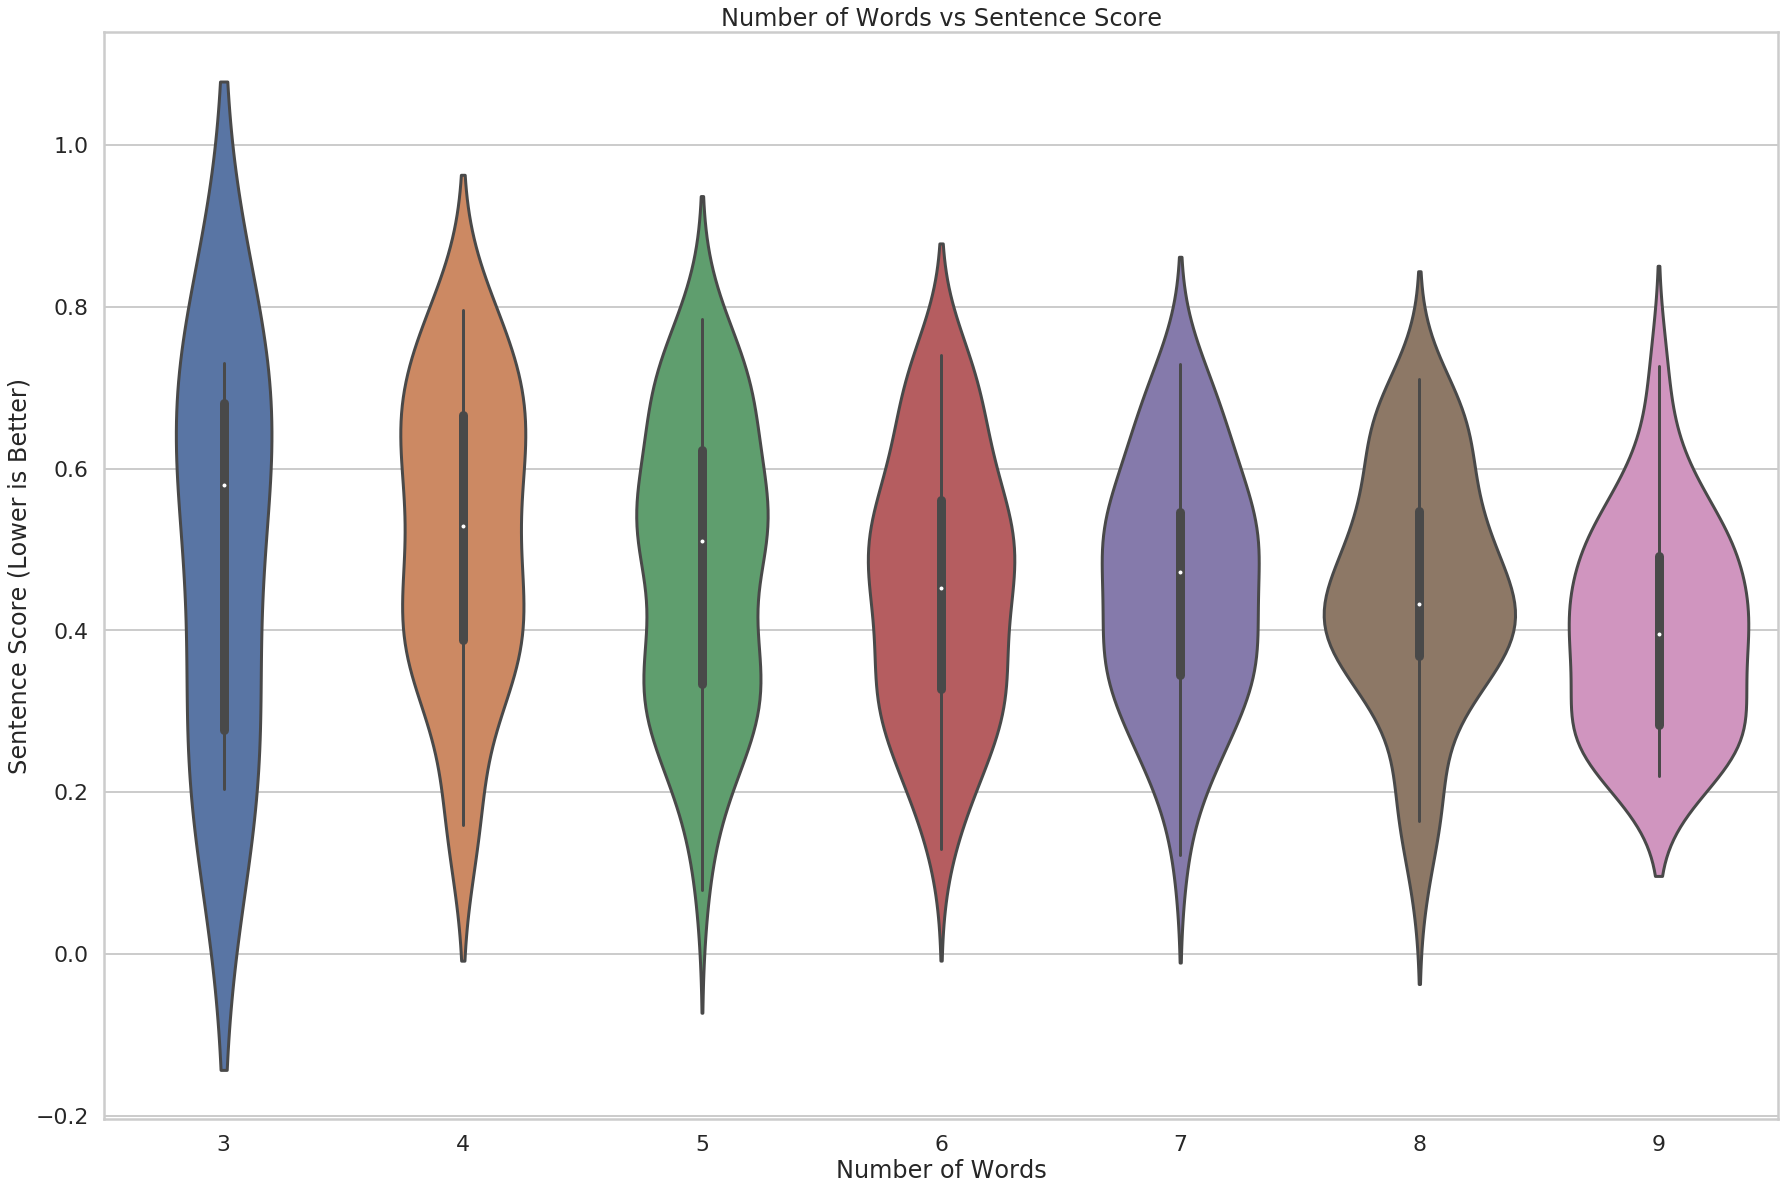

In [266]:
ax = sns.violinplot(x="Sentence Length", y="Summary Scores", data=summary_data, whis=np.inf)
# ax = sns.stripplot(x="Sentence Length", y="Summary Scores", data=summary_data, size=15, jitter=True, color="0.3")
font_size = 50
plt.ylabel('Sentence Score (Lower is Better)')
plt.xlabel('Number of Words')
plt.title("Number of Words vs Sentence Score")
plt.savefig("./plots/NumberOfWordsVsSentenceScore.png")


# User Input
For each summarized sentence the user is given the sequence of emojis and the input sentence length. With this information the user will input their guess at the input sentence. 

In [103]:
from NaiveEmojiTranslation_V1 import EmojiSummarizationResult
from dataclasses import dataclass

@dataclass
class UserSummarization:
    """
    Struct-esque data structure that stores the machines summarization and the user's guess in one object.
    This is just syntactic sugar for a python object with some default values and type checking.
    """
    machine_summarization: EmojiSummarizationResult
    user_guess: str = ""
    difference: float = -1

In [104]:
# Array for storing the users guesses
user_summaries = []

# Loop through all generated summaries
for summary in summarized_sentences_sorted:
    # Give the user the emoji summary and the input sentence length to shoot for in summary
    print(f"Emoji Sequence: {summary.emojis}")
    print("Input sentence Length: {}".format(len(word_tokenize(" ".join(summary.n_grams)))))
    
    # Prompt the user for their translation
    translation = input("What's your translation?")
    
    # Append a new UserSummarization object with the machines summary and the users translation to the list
    user_summaries.append(UserSummarization(summary, translation))

Emoji Sequence: 🏊🌎
Input sentence Length: 7


What's your translation? Swim to your home


Emoji Sequence: 🍎😆🎍
Input sentence Length: 5


What's your translation? THe teacher loves this month


Emoji Sequence: 🚷🌉
Input sentence Length: 6


What's your translation? Don't walk when it's night


Emoji Sequence: 🏦👖🔜
Input sentence Length: 4


What's your translation? The banker works soon


Emoji Sequence: 🍧🎎
Input sentence Length: 6


What's your translation? She does not like ice cream


Emoji Sequence: 🚷🔟🎁
Input sentence Length: 5


What's your translation? Don't walk for ten minutes every dayh


Emoji Sequence: 💕🍀🎍
Input sentence Length: 9


What's your translation? Love luck and weird asian pine emoji


Emoji Sequence: 🙏🙊
Input sentence Length: 4


What's your translation? Do not talk


Emoji Sequence: 🙅💂📤
Input sentence Length: 6


What's your translation? Do not attack the guard


Emoji Sequence: 💈🍧
Input sentence Length: 8


What's your translation? Shaving the ice cream


# Scoring
To score the sentence we use sent2vec to first vectorize the sentence. This produces a 700-dimensional vector that represents the sentence as a point in space. The point is determined by the context and the content of the sentence. Two word embeddings are compared using Cosine Similarity. This measures the cosine of the angle between two vectors and is mapped from 1 - 0. With 1 being very different and 0 being exactly the same. 

In [106]:
from NaiveEmojiTranslation_V1 import s2v
from scipy.spatial.distance import cosine

results = pd.DataFrame()
results["Input"] = [summary.machine_summarization.n_grams for summary in user_summaries]
results["Emoji Sequence"] = ["".join(summary.machine_summarization.emojis) for summary in user_summaries]
results["User Guess"] = [summary.user_guess for summary in user_summaries]
results["Difference"] = [cosine(s2v.embed_sentence(summary.user_guess), s2v.embed_sentence(" ".join(summary.machine_summarization.n_grams))) for summary in user_summaries]

from IPython.display import display
display(results)

print("Average Difference: {}".format(sum(results["Difference"])/len(results["Difference"])))

,Input,Emoji Sequence,User Guess,Difference
0,"[do n't those librarian swim at, home]",🏊🌎,Swim to your home,0.835372
1,"[many teacher, laugh every, month]",🍎😆🎍,THe teacher loves this month,0.512813
2,"[do n't you walk every, evening]",🚷🌉,Don't walk when it's night,0.536855
3,"[the banker, work, quickly]",🏦👖🔜,The banker works soon,0.201708
4,"[andrew 's uncle shave every, day]",🍧🎎,She does not like ice cream,0.967725
5,"[i walk for, ten, minute]",🚷🔟🎁,Don't walk for ten minutes every dayh,0.318119
6,"[do those carpenter jump for two or, three, mo...",💕🍀🎍,Love luck and weird asian pine emoji,0.878916
7,"[do you always, talk]",🙏🙊,Do not talk,0.636829
8,"[do n't those, guard, fight nicely]",🙅💂📤,Do not attack the guard,0.500322
9,"[the barber, shave for more than an hour]",💈🍧,Shaving the ice cream,0.869723


Average Difference: 0.6258380822837353
